# Intervalos de Confiança 

Esse tema procura responder quão confiança deveríamos por em um estimador. É claro que essa pergunta tem que ser um pouco melhor descrita matematicamente. A ideia é frequentista e tem a ideia a seguinte forma: 

> O intervalo $[a,b]$, uma realização de $[A,B]$, tem 95% de confiança se em 95% do tempo, o parâmetro procurado está entre $a$ e $b$. Veja que a ideia é basicamente frequentista, dado que a interpretação está ligada à frequência quando o número de experimentos tende para infinito. (Cuidado: Não vamos falar da probabilidade do parâmetro estar em $[a,b]$, isso não faz sentido, pois $\theta$ não é uma variável aleatória, e sim um valor fixo).

### Definição 

Seja $X_1, ..., X_n \overset{iid}{\sim} F(\theta)$. Sejam $A \leq B$ duas estatísticas que possuem a propriedade, para todo $\theta$, 

$$
P(A < g(\theta) < B) \geq \gamma
$$

Chamamos $(A,B)$ de intevalo de confiança para $g(\theta)$ com coeficiente $\gamma$. O intervalo é chamado de **exato** se ao invés da desigualdade, tivermos uma igualdade. 

Após observarmos os valores de $X_1, ..., X_n$ e computarmos $A = a$ e $B = b$, o intervalo $(a,b)$ é chamado de valor observado do intervalo de confiança. 

## Intervalo de Confiança para a média de $N(\mu, \sigma^2)$

Seja $X_1, ..., X_n \sim N(\mu, \sigma^2)$. Para cada $0 < \gamma < 1$, o intervalo $(A,B)$ é intervalo de confiança exato para $\mu$ com coeficiente $\gamma$, em que:

$$
A = \bar{X}_n - T_{n-1}^{-1}\left(\frac{1 + \gamma}{2}\right)\frac{\sigma '}{n^{1/2}}
$$
$$
B = \bar{X}_n + T_{n-1}^{-1}\left(\frac{1 + \gamma}{2}\right)\frac{\sigma '}{n^{1/2}}
$$

onde $T_{n-1}$ denota a cdf da distribuição $t$ com $n-1$ graus de liberdade. 

O interessante é que isso é implicação direta da distribuição de $U = \frac{n^{1/2}(\bar{X}_n - \mu)}{\sigma '}$ que inferimos no capítulo 8.4, nesse caso, simplemente fizemos a transformação:

$$\gamma = P(-c < U < c) = P(A < \mu < B)$$ 

e $c$ é escolhido de acordo com $\gamma$.

### Implementação 

Vamos rever a informação sobre café que usamos capítulos antes para ver como isso acontece na prática.

Considere dados sobre pesos de bebês logo ao nascer. 

1. bwt: peso do bebê ao nascer. 
2. gestation: duração em dias da gestação. 
3. parity: primeiro filho ou não.
4. age: idade da mãe. 
4. height: altura da mãe em polegadas. 
5. weight: peso da mãe em pounds.  
6. smoke: se a mãe é fumante ou não. 

In [14]:
# Importando bibliotecas 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t

In [2]:
birth_df = pd.read_csv("http://people.reed.edu/~jones/141/Bwt.dat")
birth_df.head()

,bwt,gestation,parity,age,height,weight,smoke
0,120,284,0,27,62,100,0
1,113,282,0,33,64,135,0
2,128,279,0,28,64,115,1
3,108,282,0,23,67,125,1
4,136,286,0,25,62,93,0


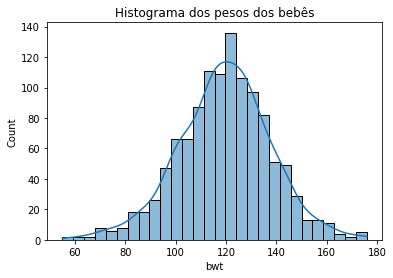

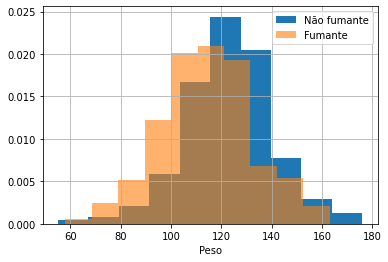

In [10]:
sns.histplot(data = birth_df.bwt, kde = True)
plt.title('Histograma dos pesos dos bebês')
plt.show()
birth_df[birth_df.smoke == 0].bwt.hist(density = True, label = 'Não fumante')
birth_df[birth_df.smoke == 1].bwt.hist(density = True, label = 'Fumante', alpha = 0.6)
plt.xlabel('Peso')
plt.legend()
plt.show()

Sabemos que essa é uma extração de uma população maior. Para conseguirmos mais amostras, vamos usar um procedimento chamado **bootstrap**. A ideia desse procedimento é criar um novas amostras a partir de uma amostra inicial, usando `replace = True` como diferencial. Vou fazer esse procedimento diversar vezes e ir calculando a média amostral. Como a média amostral é uma variável aleatória, vamos obter um histograma das realizações. 

Vamos supor que o peso $W_i$ da criança $i$ vem de uma distribuição com parâmetros $\mu$ e $\sigma^2$ desconhecidos. Nesse caso, $\bar{W}_i$ virá de uma distribuição normal com parâmetros $\mu$ e $\sigma^2/n$. 

In [4]:
ite = 10000
n = 200

bootstrap_means = np.zeros(ite)
for i in range(ite):
    bootstrap_sample = birth_df.sample(n = n, replace = True, random_state=i)
    bootstrap_means[i] = bootstrap_sample.bwt.mean()

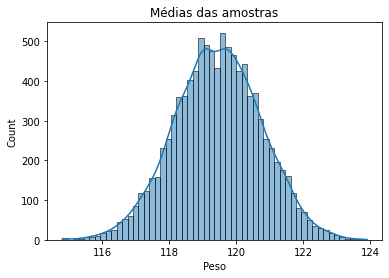

In [13]:
sns.histplot(bootstrap_means, kde = True)
plt.title("Médias das amostras")
plt.xlabel('Peso')
plt.show()

Vamos calcular o nosso intervalo de confiança com $\gamma = 0.95$. Temos que:

In [18]:
gamma = 0.95

A = lambda x: np.mean(x) - t.ppf(q = (1 + gamma)/2, df = len(x) - 1)*np.std(x, ddof = 1)/len(x)**(1/2)
B = lambda x: np.mean(x) + t.ppf(q = (1 + gamma)/2, df = len(x) - 1)*np.std(x, ddof = 1)/len(x)**(1/2)

In [45]:
ite = 100
n = 500

bootstrap_intervals  = np.zeros((ite,2))
for i in range(ite):
    bootstrap_sample = birth_df.sample(n = n, replace = True, random_state=i)
    bootstrap_intervals[i,0] = A(bootstrap_sample.bwt)
    bootstrap_intervals[i,1] = B(bootstrap_sample.bwt)
    
out_values = np.where((bootstrap_intervals[:,0] > 119.5) | (bootstrap_intervals[:,1] < 119.5))

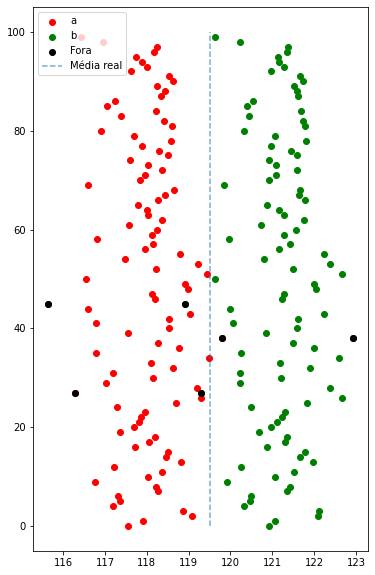

In [51]:
plt.figure(figsize = (6,10))
plt.scatter(bootstrap_intervals[:,0], np.arange(0,ite), color = 'red', label = 'a')
plt.scatter(bootstrap_intervals[:,1], np.arange(0,ite), color = 'green', label = 'b')
plt.scatter(bootstrap_intervals[out_values[0],0], out_values[0], color = 'black', label = 'Fora')
plt.scatter(bootstrap_intervals[out_values[0],1], out_values[0], color = 'black')
plt.vlines(119.5, ymin = 0, ymax = ite, linestyle = '--', alpha = 0.6, label = 'Média real')
plt.legend()
plt.show()

## Interpretação 

Estamos fazer uma afirmação probabilística sobre o intervalo $(A,B)$ antes de observar os dados. Após observarmos os dados, não podemos interpretar $(a,b)$ como um intervalo em que temos 95% de confiança de $g(\theta)$ estar no intervalo. Antes de observarmos as amostras, temos a confiança de que 95% dos intervalos conterão $\mu$. 

### Sem simetria

Construimos anteriormente um intervalo simétrico, onde a estatística $U$ acima mencionada estaria entre $-c$ e $c$ com probabilidade $\gamma$. Mas podemos desenvolver intervalos não simétricos também. Uma forma que podemos fazer isso é escolhendo $\gamma_1$ e $\gamma_2$, tal que $\gamma_2 - \gamma_1 = \gamma$. Assim: 

$$P\left(T_{n-1}^{-1}(\gamma_1) < U < T_{n-1}^{-1}(\gamma_2)\right) = \gamma$$

Talvém vc esteja se perguntando: porque escolher $\gamma_1, \gamma_2$ dessa forma? Bom: 

$$
\begin{split}
\gamma &= P\left(T_{n-1}^{-1}(\gamma_1) < U < T_{n-1}^{-1}(\gamma_2)\right) \\
&= P\left(U < T_{n-1}^{-1}(\gamma_2)\right) - P\left(U \leq T_{n-1}^{-1}(\gamma_1)\right) \\
&= \gamma_2 - \gamma_1
\end{split}
$$

## Intervalos de Confiança Unilateral 

### Definição 

Seja $X_1, ..., X_n \overset{idd}{\sim} F(\theta)$. Sejam $A$ e $B$ duas estatísticas tais que: 

$$
P(A < g(\theta)) \geq \gamma
$$

$$
P(B > g(\theta)) \geq \gamma
$$

Então $(A, \infty)$ e $(-\infty, B)$ são chamados de intervalos de confiaça unilaterais para $g(\theta)$ de coeficiente $\gamma$ ou percentil $100\gamma$. No caso de $A$ $100\gamma$ porcento abaixo e no caso de $B$ a cima. Se vale a igualdade, dizemos que o intervalor é exato.  

## Intervalo unilateral para a média de $N(\mu,\sigma^2)$

Nas mesma condições do teorema anterior, mas as estatísticas para baixo e para cima com coeficiente $\gamma$ para $\mu$ são: 

$$
A = \bar{X}_n - T_{n-1}^{-1}\left(\gamma\right)\frac{\sigma '}{n^{1/2}}
$$
$$
B = \bar{X}_n + T_{n-1}^{-1}\left(\gamma\right)\frac{\sigma '}{n^{1/2}}
$$

## Pivotal 

Seja $X_1, ..., X_n \overset{idd}{\sim} F(\theta)$. Seja $V(\vec{X},\theta)$ uma variável aleatória cuja distribuição é a mesma para $\theta$. Chamamos $V$ de **quantidade pivotal**. 

### Teorema 

Seja $X_1, ..., X_n \overset{idd}{\sim} F(\theta)$. Suponha que 

1. Exista $V$ pivotal. 
2. A cdf $G$ de $V$ é contínua. 
3. Exista função $r$ tal $r(V(X,\theta), X) = g(\theta)$, ou seja, é uma espécie de "inversa". 
4. $r(v,x)$ (3) é uma função estritamente crescente em $v$ para todo $x$. 

Então 

$$
A = r(G^{-1}(\gamma_1), X)
$$
$$
B = r(G^{-1}(\gamma_2), X)
$$

são os pontos extremos do intervalo de confiança exato para $g(\theta)$ de coeficiente $\gamma = \gamma_2 - \gamma_1$. Se $r$ é estritamente decrescente, invertemos $A$ e $B$. 

*Obs.: Ainda podemos usar o Teorema Central do Limite para obter intervalos de confiança assintóticos.*

## Exemplo com Regressão Linear

O dataset que utilizei anteriormente não é muito bom para esse exemplo, mas eu vou usar, de qualquer forma, para entendermos o processo e como pode nos ajudar o intervalo de confiança. 

Em uma Regressão Linear, queremos dizer aferir uma relação linear entre duas variáveis, isto é, queremos dizer que uma variável pode ser obtida pela outra através de uma reta, mais um erro aleatório. Suponha que queremos estimar $Y$ o peso da criança ao nascer, sabendo a informação do tempo de gestação $X$ e que 

$$
Y = aX + b + E,
$$

onde $E \sim N(0,\sigma^2)$. Nesse caso, estamos dizendo que $Y|X \sim N(aX + b, \sigma^2)$. Queremos estimar $a$ e $b$ de forma que tenhamos o melhor ajuste possível. Esse tema em específico não me interessa. Entretanto, podemos dizer que queremos estimar $aX + b$, a média de uma normal, mas que muda para cada $X = x$ observado. 

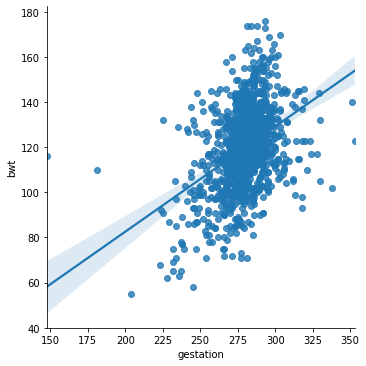

In [69]:
sns.lmplot(x = 'gestation', y = 'bwt', data = birth_df, height = 5, ci = 95)

O resultado não foi muito bom (na verdade eu já imaginava isso). Mas o interessante é tentar refletir o que essas bandas significam? Por que os pontos não estão nela? Esperávamos que estivésse? E por que ela diminui a variância com o número de pontos? 

Essas perguntas vão ser devidamente respondidas no próximo curso de Estatística!

Mas eu já vou adiantando que esse intervalo de confiança é para a média estimada. 